# COBRApy

COBRApy is a package for constraint-based modeling of biological networks written in Python.

This tool allows loading and inspecting Genome-Scale Metabolic (GEM) models written in the Systems Biology Markup Language (SBML) format.

Using COBRApy, one can analyse the following model contents:
1. Reactions
2. Metabolites
3. Genes
4. Exchange reactions (Environmental Conditions)

COBRApy allows manipulating the contents of a GEM model. For instance, one can edit reactions' flux bounds, knock out a metabolic gene, or change the environmental conditions.

Phenotype prediction can be simulated with several flux analysis methods implemented in COBRApy. These include Flux Balance Analysis (FBA), Parsimonious FBA, or Flux Variability Analysis (FVA).

The simulation of gene and reaction deletions for a given GEM model is a simple and straightforward process. One can simulate single or double knock outs using one of the flux analysis methods mentioned above.

## Instalation


### Requirements
The following requirements need to be installed to use COBRApy:
- Python 3.6 or higher
- pip must be installed
- GLPK solver is used by default but CPLEX is prefered


### How to install COBRApy?
```
pip install cobra
```

# Exercise 5 - Phenotype prediction

## Working with a GEM model

For this practical session, we will be using the following model:
- _iMM904_ model which contains the whole metabolism of _S. cerevisiae_ -> file: ../data/iMM904.xml

You can read more about _S. cerevisiae_ iMM804 model (Mo et al 2009) in the following links:
- https://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-3-37
- http://bigg.ucsd.edu/models/iMM904

This exercise consists of exploring the phenotype prediction tools of COBRApy. Thus, the following steps will be followed:
- Loading the model with COBRApy;
- Perform a FBA simulation using an aerobic/anaerobic medium;
- Perform reaction and gene deletions
- Perform other flux analysis methods, such as pFBA, FVA, ROOM and MOMA;
- Analyzing the model essential 

In [1]:
# importing cobra
import cobra

# Loading a model
model_path = '../data/iMM904.xml'
model = cobra.io.read_sbml_model(model_path)

model

Name,iMM904
Memory address,0x024841b23608
Number of metabolites,1226
Number of reactions,1577
Number of groups,0
Objective expression,1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
Compartments,"cytosol, extracellular space, mitochondria, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, golgi apparatus, nucleus"


## Phenotype Prediction

### Flux Balance Analysis (FBA) - Aerobiosis

In [2]:
#check model exchanges
for exchange in model.exchanges:
    print(exchange.name, '->', exchange.bounds)

Episterol ester  yeast specific exchange -> (0.0, 999999.0)
Episterol exchange -> (0.0, 999999.0)
Ergosterol exchange -> (0.0, 999999.0)
Ergosterol ester  yeast specific exchange -> (0.0, 999999.0)
1 3 beta D Glucan exchange -> (0.0, 999999.0)
Ethanolamine exchange -> (0.0, 999999.0)
2 Hydroxybutyrate exchange -> (0.0, 999999.0)
Ethanol exchange -> (0.0, 999999.0)
Fe2+ exchange -> (-999999.0, 999999.0)
Fecosterol exchange -> (0.0, 999999.0)
2 methylbutyl acetate exchange -> (0.0, 999999.0)
2 methylbutyraldehyde exchange -> (0.0, 999999.0)
2 methyl 1 butanol exchange -> (0.0, 999999.0)
2 methylpropanal exchange -> (0.0, 999999.0)
2 phenylethanol exchange -> (0.0, 999999.0)
Fecosterol ester  yeast specific exchange -> (0.0, 999999.0)
FMN exchange -> (0.0, 999999.0)
3 Carboxy 3 hydroxy 4 methylpentanoate exchange -> (0.0, 999999.0)
3 Methylbutanal exchange -> (0.0, 999999.0)
Formate exchange -> (0.0, 999999.0)
D-Fructose exchange -> (0.0, 999999.0)
3mop exchange -> (0.0, 999999.0)
4-Amino

In [16]:
model.exchanges.EX_o2_e

Reaction identifier,EX_o2_e
Name,O2 exchange
Memory address,0x2484b7f7108
Stoichiometry,o2_e <=> O2 O2 <=>
GPR,
Lower bound,-2.0
Upper bound,999999.0


In [17]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,1.611,0,0.00%
o2_e,EX_o2_e,2,0,0.00%
pi_e,EX_pi_e,0.05691,0,0.00%
so4_e,EX_so4_e,0.02225,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-18.02,1,36.29%
etoh_e,EX_etoh_e,-15.82,2,63.70%
for_e,EX_for_e,-0.001488,1,0.00%
h2o_e,EX_h2o_e,-5.64,0,0.00%


### Flux Balance Analysis (FBA) - Anaerobiosis

In [18]:
# setting the environmental conditions to replicate an anaerobic medium
with model:
    o2_exchange = model.reactions.get_by_id('EX_o2_e')
    o2_exchange.bounds = (0, 1000)
    model_summary = model.summary()
model_summary

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,0.5,6,100.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-1,1,33.33%
etoh_e,EX_etoh_e,-1,2,66.67%


### Flux Variability Analysis (FVA)

In [19]:
#performing fva simulation
fva_solution = cobra.flux_analysis.flux_variability_analysis(model, fraction_of_optimum=0.1)
fva_solution

,minimum,maximum
CITtcp,0.000000,0.000000
13BGH,0.000000,10.823974
13BGHe,0.000000,0.000000
13GS,0.032667,10.856641
16GS,0.000000,0.000000
...,...,...
PYDXO,0.000000,0.000000
PYK,0.000000,41.459171
PYNP2r,-10.823974,10.823974
PYR5CDm,0.000000,9.426427


In [20]:
# maximum theoretical production rates of Ethanol (EX_eth_e)

print(f'Theoretical production rate interval for Ethanol:', fva_solution.loc['EX_etoh_e', 'minimum'], 'to', fva_solution.loc['EX_etoh_e', 'maximum'], 'mmol/gDW/h')

Theoretical production rate interval for Ethanol: 0.0 to 19.647173465947198 mmol/gDW/h


#### Parsimonious Flux Balance Analysis (pFBA)

In [7]:
#performing pfba simulation
pfba_solution = cobra.flux_analysis.pfba(model)
model.summary(pfba_solution)

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,1.611,0,0.00%
o2_e,EX_o2_e,2,0,0.00%
pi_e,EX_pi_e,0.05691,0,0.00%
so4_e,EX_so4_e,0.02225,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-18.02,1,36.29%
etoh_e,EX_etoh_e,-15.82,2,63.70%
for_e,EX_for_e,-0.001488,1,0.00%
h2o_e,EX_h2o_e,-5.64,0,0.00%


### Simulating Deletions

#### Knock outs

In [21]:
#knock out the ENO reaction
with model:
    model.reactions.ENO.knock_out()
    fba_solution = model.optimize()
    print('ENO mutant growth rate: ', fba_solution.fluxes['BIOMASS_SC5_notrace'])
    print('ENO flux rate: ', fba_solution.fluxes['ENO'])

ENO mutant growth rate:  0.051686721033667254
ENO flux rate:  0.0


In [22]:
#knock out the ACS gene
with model:
    model.genes.YLR153C.knock_out()
    fba_solution = model.optimize()
    print('ACS mutant growth rate: ', fba_solution.fluxes['BIOMASS_SC5_notrace'])
    print('ACS flux rate: ', fba_solution.fluxes['ACS'])

ACS mutant growth rate:  0.0
ACS flux rate:  0.0


In [23]:
#knock out the PGM GPRs
with model:
    model.genes.YKL152C.knock_out()
    model.genes.YDL021W.knock_out()
    model.genes.YOL056W.knock_out()
    fba_solution = model.optimize()
    print('PGM mutant growth rate: ', fba_solution.fluxes['BIOMASS_SC5_notrace'])
    print('PGM flux rate: ', fba_solution.fluxes['PGM'])

PGM mutant growth rate:  0.05168672103366752
PGM flux rate:  0.0


In [24]:
#all knock outs at once
with model:
    fba_solution = model.optimize()
    model.reactions.ENO.knock_out()
    model.genes.YLR153C.knock_out()
    model.genes.YKL152C.knock_out()
    model.genes.YDL021W.knock_out()
    model.genes.YOL056W.knock_out()
    mutant_fba = model.optimize()
    print('Wild type growth rate: ', fba_solution.fluxes['BIOMASS_SC5_notrace'])
    print('Mutant growth rate: ', mutant_fba.fluxes['BIOMASS_SC5_notrace'])

Wild type growth rate:  0.28786570370401576
Mutant growth rate:  0.0


#### Single Deletions

In [32]:
#single reaction deletion
double_reaction_deletion_results = cobra.flux_analysis.single_reaction_deletion(model)
double_reaction_deletion_results

,ids,growth,status
0,{MELTGH},0.287866,optimal
1,{GLYOXm},0.287866,optimal
2,{LEUt2r},0.287866,optimal
3,{DTTPt},0.287866,optimal
4,{DPGM},0.287866,optimal
...,...,...,...
1572,{GTHRDabcv},0.287866,optimal
1573,{GTHS},0.287866,optimal
1574,{EX_iamoh_e},0.287866,optimal
1575,{PAPt},0.287866,optimal


In [33]:
#single gene deletion
single_gene_deletion_results = cobra.flux_analysis.single_gene_deletion(model)
single_gene_deletion_results

,ids,growth,status
0,{YOR040W},0.287866,optimal
1,{YOR393W},0.287866,optimal
2,{YPL276W},0.287866,optimal
3,{YNR033W},0.287866,optimal
4,{YER178W},0.281522,optimal
...,...,...,...
900,{YJL153C},0.000000,optimal
901,{YDR019C},0.287866,optimal
902,{YJR016C},0.000000,optimal
903,{YIL094C},0.000000,optimal


### Production envelopes

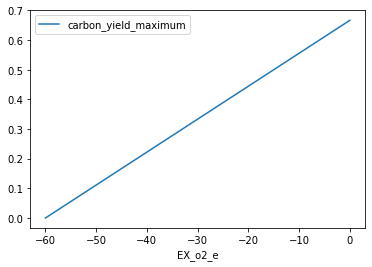

In [31]:
# Production envolope for Ethanol production as a function of oxygen consumption rate
with model:
    model.exchanges.EX_o2_e.bounds = (-60, 1000)
    prod_env = cobra.flux_analysis.production_envelope(model, ["EX_o2_e"], objective="EX_etoh_e", carbon_sources="EX_glc__D_e")
prod_env.plot(kind='line', x='EX_o2_e', y='carbon_yield_maximum')